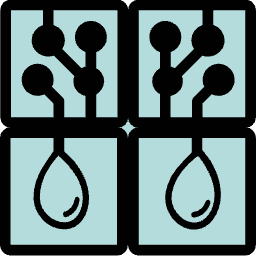

In [ ]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler

In [2]:
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Version: {torch.version.cuda}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")

PyTorch Version: 2.4.0+cu121
CUDA Available: True
CUDA Version: 12.1
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
Covid = 'C:\\Users\\Ali khatami\\Desktop\\Uni\\Challenge2\\Dt\\Covid CT scan\\COVID'
Non_covid = 'C:\\Users\\Ali khatami\\Desktop\\Uni\\Challenge2\\Dt\\Covid CT scan\\non-COVID'

In [5]:
image_size = (256, 256)

def read_img(folder_path, category):
    image = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, image_size)
            image.append((img, category))

    return image 

In [11]:
# Define image transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale (if needed)
    transforms.Resize((64, 64)),                  # Resize to (64x64)
    transforms.ToTensor(),                        # Convert to a PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

In [19]:
data_path = "C:\\Users\\Ali khatami\\Desktop\\Uni\\Challenge2\\Dt\\Covid CT scan\\Images"
dataset = datasets.ImageFolder(root=data_path, transform=transform)
batch_size = 8
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle= True)
val_loader = DataLoader(val_dataset, batch_size= batch_size, shuffle= False)

In [8]:
model = nn.Sequential(
nn.Conv2d(1, 32, kernel_size=3),
nn.ReLU(),
nn.MaxPool2d(kernel_size= 2, stride= 2),
nn.Conv2d(32, 64, kernel_size= 3),
nn.ReLU(),
nn.Dropout(0.5),
nn.MaxPool2d(kernel_size=2, stride=2),
nn.Flatten(),
nn.Linear(64 * 14 * 14, 128),
nn.ReLU(),
nn.Dropout(0.5),
nn.Linear(128, 1),
nn.Sigmoid()
).to(device)
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr= 0.001)

img_size = (64, 64)
batch_size= 8

inputs = torch.randn(batch_size, 1, img_size[0], img_size[1]).to(device)
labels = torch.rand(batch_size, 1).to(device)

outputs = model(inputs)
loss = criterion(outputs, labels)

optimizer.zero_grad()
loss.backward()
optimizer.step()

print(f"loss: {loss.item()}")

loss: 0.7025901675224304


In [22]:
epochs = 15
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)

    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct / (total * 100)

    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}%")

Epoch [1/15], Train Loss: 0.1454, Val Loss: 0.2414, Val Accuracy: 0.01%
Epoch [2/15], Train Loss: 0.1281, Val Loss: 0.2266, Val Accuracy: 0.01%
Epoch [3/15], Train Loss: 0.1249, Val Loss: 0.2214, Val Accuracy: 0.01%
Epoch [4/15], Train Loss: 0.1398, Val Loss: 0.2504, Val Accuracy: 0.01%
Epoch [5/15], Train Loss: 0.1282, Val Loss: 0.2218, Val Accuracy: 0.01%
Epoch [6/15], Train Loss: 0.1032, Val Loss: 0.2185, Val Accuracy: 0.01%
Epoch [7/15], Train Loss: 0.1090, Val Loss: 0.2176, Val Accuracy: 0.01%
Epoch [8/15], Train Loss: 0.1098, Val Loss: 0.2202, Val Accuracy: 0.01%
Epoch [9/15], Train Loss: 0.1236, Val Loss: 0.2663, Val Accuracy: 0.01%
Epoch [10/15], Train Loss: 0.1124, Val Loss: 0.2138, Val Accuracy: 0.01%
Epoch [11/15], Train Loss: 0.1017, Val Loss: 0.2135, Val Accuracy: 0.01%
Epoch [12/15], Train Loss: 0.1285, Val Loss: 0.2269, Val Accuracy: 0.01%
Epoch [13/15], Train Loss: 0.1081, Val Loss: 0.2104, Val Accuracy: 0.01%
Epoch [14/15], Train Loss: 0.0972, Val Loss: 0.2081, Val Acc